# 6.6 Sourcing and Analizying Time-Series Data

## This script contains the following:

### 1. Importing libraries and Data

### 2. Subsetting, wrangling and cleaning time-series data

### 3. Times Series analysis: decomposition

### 4. Testing for stationarity

### 5. Stationaring the Airbnb Madrid´s Data

### 1. Importing libraries and Data

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
from datetime import datetime
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [2]:
# Creating data path and importing data

path=r'C:\Users\carol\Documents'

In [3]:
df = pd.read_csv(os.path.join(path,'6.6 Sourcing and analysing time series data','df_listings_merged_6.6.csv'))

In [4]:
df.head(5)

,last_review_x,number_of_reviews_x
0,29/05/2024,186
1,15/05/2024,30
2,NaN,0
3,NaN,0
4,NaN,0


In [5]:
df.shape

(11767, 2)

In [6]:
df.columns

Index(['last_review_x', 'number_of_reviews_x'], dtype='object')

In [7]:
# Check for missing values (you shouldn't have any)

df.isnull().sum() 

last_review_x          1946
number_of_reviews_x       0
dtype: int64

In [8]:
# Remove null values 

df2 = df.dropna()

In [9]:
#Checking data after removing NaN values

df2.isnull().sum() 

last_review_x          0
number_of_reviews_x    0
dtype: int64

In [10]:
df2.head(5)

,last_review_x,number_of_reviews_x
0,29/05/2024,186
1,15/05/2024,30
7,08/11/2014,11
8,02/02/2020,10
16,20/09/2018,1


### 2. Create a Subset

In [11]:
# Create a Subset with last review and number of reviews
df2 = df2[['last_review_x', 'number_of_reviews_x']]  # Select relevant columns

In [12]:
df2.head(5)

,last_review_x,number_of_reviews_x
0,29/05/2024,186
1,15/05/2024,30
7,08/11/2014,11
8,02/02/2020,10
16,20/09/2018,1


**Note** df2 is a serie and we need to turn it into a DF having date as a index

In [13]:
# Turn df_sub into data frame

df2 = df2.reset_index()
df2.head(5)

,index,last_review_x,number_of_reviews_x
0,0,29/05/2024,186
1,1,15/05/2024,30
2,7,08/11/2014,11
3,8,02/02/2020,10
4,16,20/09/2018,1


In [16]:
# Convert 'last_review_x' to datetime format, with day first
df2['datetime'] = pd.to_datetime(df2['last_review_x'], dayfirst=True, errors='coerce')

# Set the 'datetime' as the index of the dataframe
df2 = df2.set_index('datetime')

# Drop the "last_review_x" and the "index" columns, if the "index" is redundant
df2.drop(['last_review_x', 'index'], axis=1, inplace=True)

# Check the updated dataframe
df2.head()

,number_of_reviews_x
datetime,
2024-05-29,186
2024-05-15,30
2014-11-08,11
2020-02-02,10
2018-09-20,1


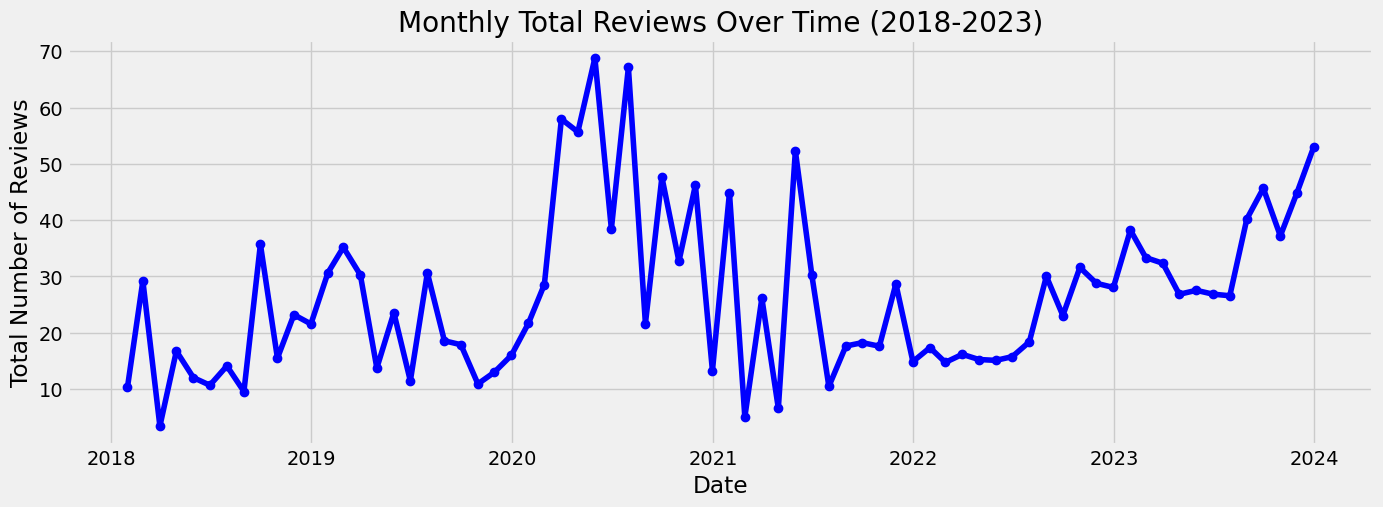

In [19]:
# Resample the data by month and calculate the average number of reviews per month
df_monthly = df2['number_of_reviews_x'].resample('M').mean()

# Ensure the index has a monthly frequency
df_monthly = df_monthly.asfreq('M')

# Filter the data to only include dates between 2018 and 2023
df_filtered = df_monthly.loc['2018':'2023']

# Plot the filtered data
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_filtered, marker='o', linestyle='-', color='b')
plt.title("Monthly Total Reviews Over Time (2018-2023)")
plt.xlabel("Date")
plt.ylabel("Total Number of Reviews")
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

**Note** This chart shows that there has been a significant recent increase in review activity, possibly indicating a rise in business listings, customer engagement, or other relevant market factors.

### 3. time-series: decomposition

In [20]:
df_filtered.isnull().sum()

0

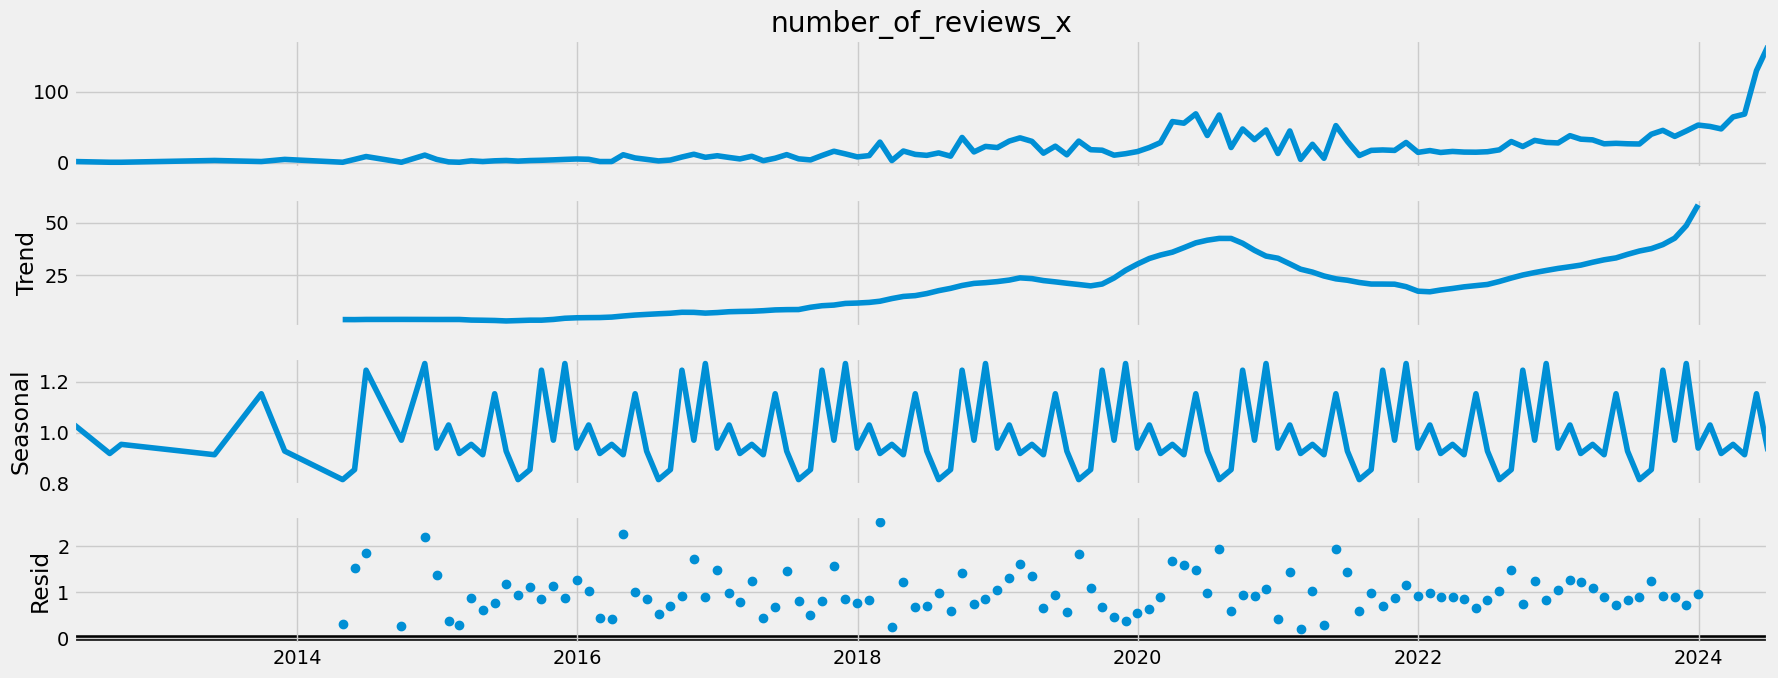

In [28]:
# Decompose the time series using a multiplicative model
# You must specify a period for decomposition, which is 12 for monthly data

decomposition = sm.tsa.seasonal_decompose(df_filtered, model='multiplicative', period=12)

# Plot the decomposition components (trend, seasonal, residual)
fig = decomposition.plot()
fig.set_size_inches(18, 7)  # Set figure size to be larger (width=18, height=7 in inches)
plt.show()

1. **Trend**:The trend component shows the underlying direction of the data, filtering out short-term fluctuations. 
   Is relatively flat from 2014 to 2017, followed by a slow upward movement between 2018 and 2020. A noticeable increase is seen after 2021, which  grows sharply toward 2024. This indicates a **long-term increase in the number of reviews, especially in the last couple of years**.

2. **Seasonal**  captures the repeating short-term patterns in the data. It shows cyclical variations that are consistent within each year.The seasonal pattern is relatively stable throughout the period, indicating that review patterns follow a yearly cycle.

3. **Residual**  represents the noise or random fluctuations in the data after removing the trend and seasonal components.The residuals suggest that the model explains most of the variance, as there are no large, unexplained fluctuations.

### 4. Test for Stationary

In [31]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_filtered)

Dickey-Fuller Stationarity test:
Test Statistic                   1.584302
p-value                          0.997810
Number of Lags Used              2.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


**Interpretation of the Dickey-fuller tests results**
* The time series is non-stationary because the p-value is very high (0.997810), and the test statistic is far above the critical values.
* This suggests that the time series has trends, seasonality, or other patterns that prevent it from being stationary. To make it stationary, you might need to apply transformations such as differencing, logarithmic transformations, or detrending.

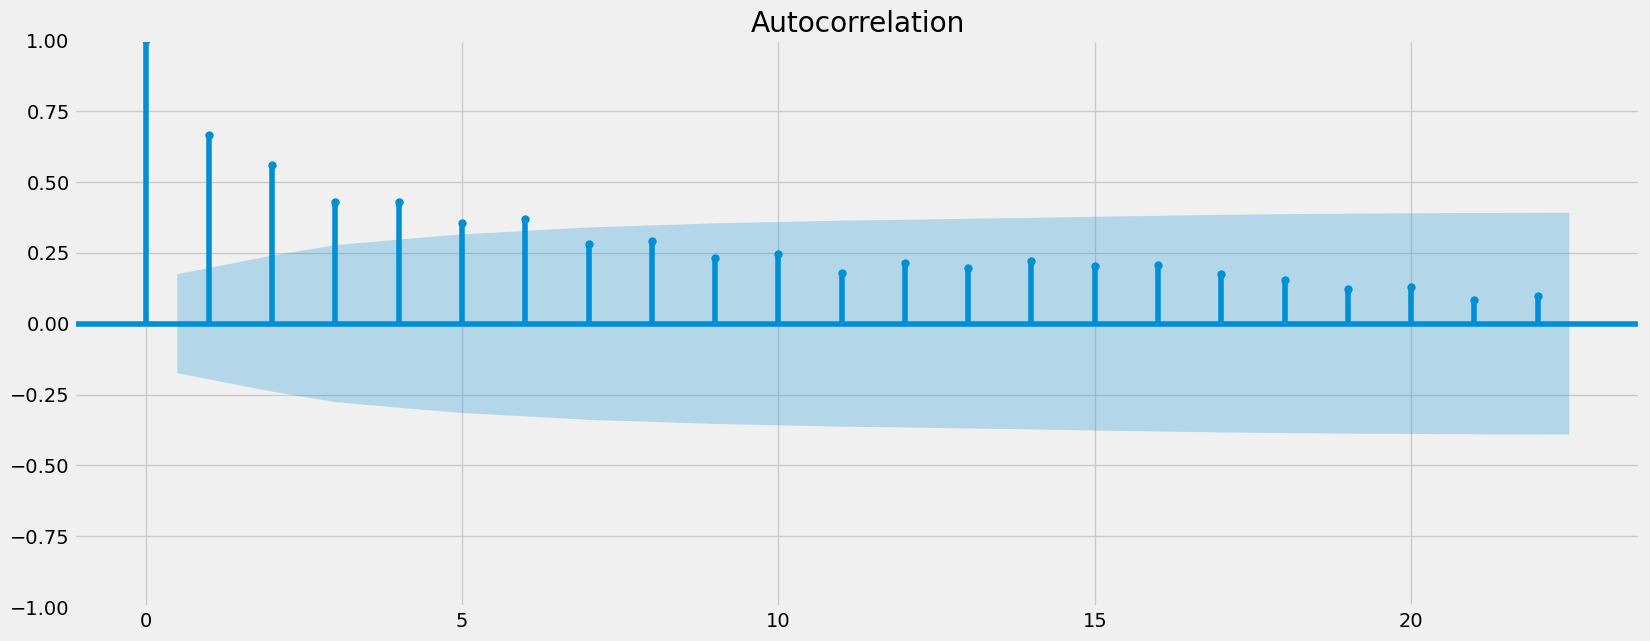

In [32]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_filtered)
plt.show()

These patterns suggest that the time series has memory and trends that persist for a few months, which is typical of non-stationary data.

In [33]:
# Apply first differencing to remove the trend
df_diff = df_filtered.diff().dropna()

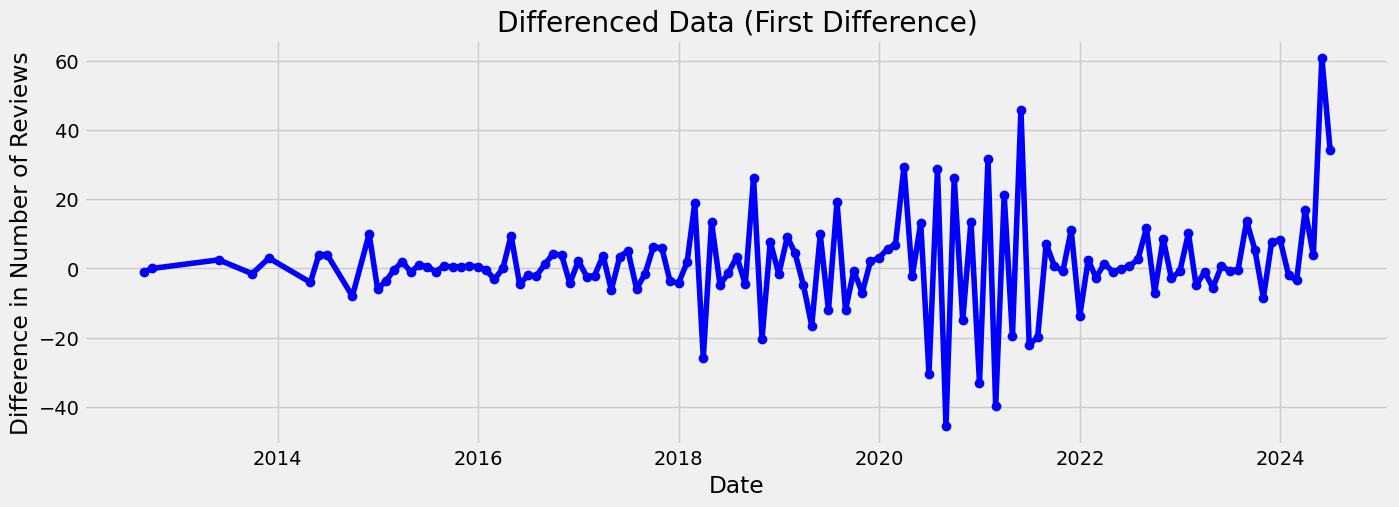

In [34]:
# Plot the differenced data
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_diff, marker='o', linestyle='-', color='b')
plt.title("Differenced Data (First Difference)")
plt.xlabel("Date")
plt.ylabel("Difference in Number of Reviews")
plt.grid(True)
plt.show()

In [35]:
# Test for stationarity using Dickey-Fuller test after differencing
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.964282
p-value                          0.000026
Number of Lags Used              1.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


1. **Test Statistic**:

* **Before differencing**: The test statistic was 1.584302, which is positive and far from the critical values, indicating that the series was non-stationary.
* **After differencing**: The test statistic is now -4.964282, which is much lower than all the critical values, **indicating that the series is stationary.**

2. **p-value:**

* **Before differencing**: The p-value was 0.997810, which is very high. This meant we could not reject the null hypothesis (the series was non-stationary).
* **After differencing**: The p-value is now 0.000026, which is well below 0.05, meaning **we can reject the null hypothesis and conclude that the series is now stationary.**

3. **Critical Values:**

The critical values have remained the same:
1% level: -3.484667
5% level: -2.885340
10% level: -2.579463
Before differencing: The test statistic was higher than all critical values, indicating non-stationarity.
After differencing: The test statistic is now much lower than the critical values, confirming stationarity.


**Summary of the Change:**
Before differencing, the series was non-stationary, with a high p-value and a positive test statistic.
After applying first differencing, the series became stationary, as indicated by the highly negative test statistic and the very low p-value.
This means that the **time series now has no significant trend or seasonality, and it's ready for further analysis** (e.g., ARIMA modeling).

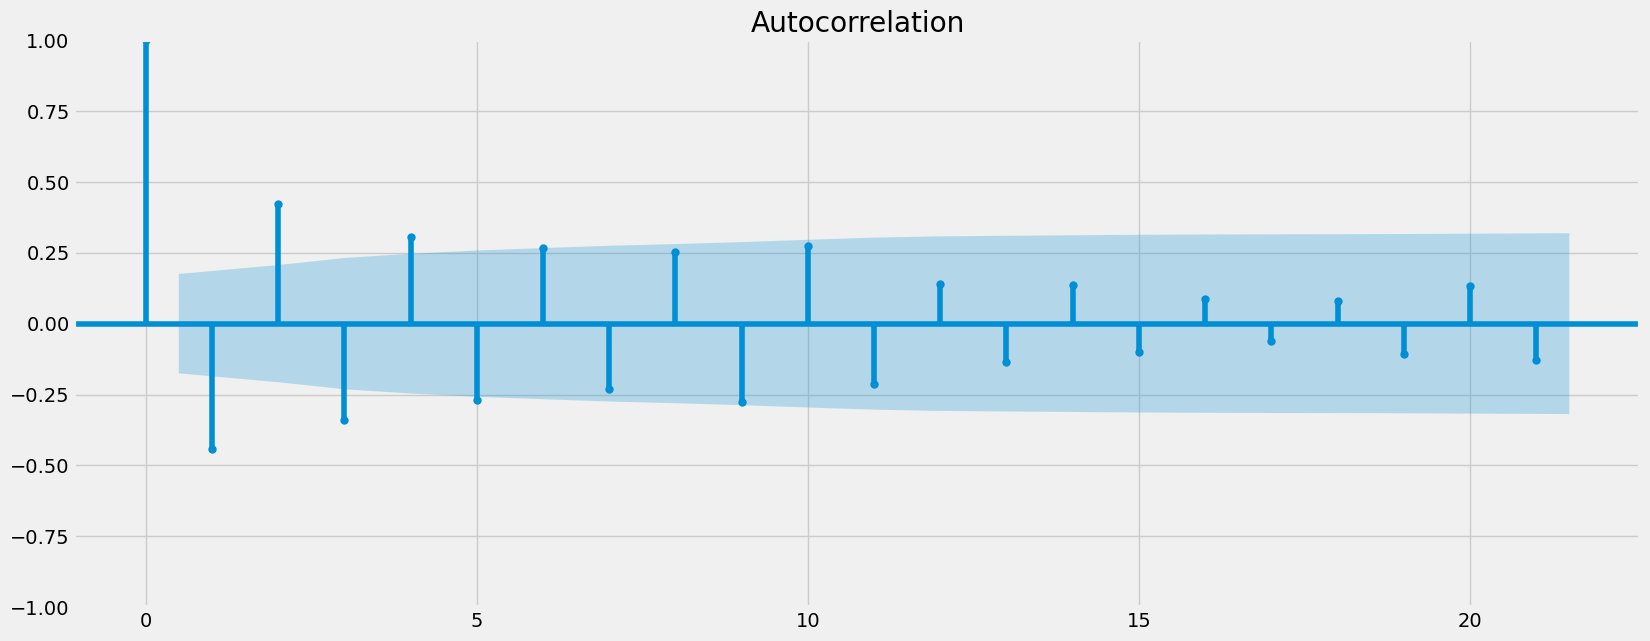

In [36]:

plot_acf(df_diff)
plt.show()

This new autocorrelation plot is typical of a **stationary time series**, with most autocorrelations being insignificant and within the confidence interval, indicating that the differencing transformation successfully removed trends and seasonality from the data.